In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_absolute_percentage_error,r2_score
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, LSTM,GRU
from tensorflow import keras

In [2]:
data = pd.read_csv("D:\\học đại học\\20222\\machine learning\\data.csv")

In [3]:
data=data[::-1]
data = data.reset_index(drop=True)

time=data['Date']
data=data.drop(['Date','BTC_change'], axis=1)

target="BTC_close"

In [4]:
data.head()

,BTC_close,BTC_open,BTC_high,BTC_low,difficulty,addresses_active_count,sum_lock_weight,mean_lock_size_ytes,total_fees_usd,mean_hash_rate,...,ETH,LTC,XRP,DOGE,COPPER,GOLD,SILVER,SPX,JP225,DJI
0,415.8,412.8,417.5,410.3,158427203767,445273,426654988,688153.206452,17312.723752,1.220696e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,419.1,415.8,422.4,415.1,158427203767,434658,398582424,622785.037500,17101.930760,1.260073e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,410.4,419.1,420.7,407.0,158427203767,374730,331208848,575015.361111,13984.439830,1.134066e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,412.4,410.4,415.9,409.6,158427203767,421585,334817852,629356.864662,14606.780891,1.047436e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,414.3,412.4,416.1,411.2,158427203767,451902,437739524,719966.322368,16892.976657,1.197070e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
target=np.array(target)
target.shape

()

In [6]:
train_data= data.copy().iloc[:int(0.7*len(data)),:]
train_np= train_data.to_numpy()
val_data=data.copy().iloc[int(0.7*len(data)):int(0.85*len(data)),:]
val_np=val_data.to_numpy()
test_data=data.copy().iloc[int(0.85*len(data)):,:]
test_np=test_data.to_numpy()

In [7]:
train_np = np.asarray(train_np).astype('float32')
val_np = np.asarray(val_np).astype('float32')
test_np = np.asarray(test_np).astype('float32')

In [8]:
time_step=30
train_time_line=[]
val_time_line=[]
test_time_line=[]

In [9]:
def scale_sequence_data(df,timesteps ,close_col_idx):
    x = []
    y = []
    timeLine=[]
    for i in range(len(df)-timesteps):    
        scaler=MinMaxScaler()      
        scaler.fit(df[i:i+timesteps,:])
        timeLine.append((scaler.data_min_[close_col_idx],scaler.data_max_[close_col_idx]))
        x.append(scaler.transform(df[i:i+timesteps,:]))
        value=df[i+timesteps].reshape(1,-1)
        value=scaler.transform(value)
        y.append(value[:,close_col_idx])

    return np.array(x),np.array(y),timeLine


In [10]:
train_x, train_y,train_time_line = scale_sequence_data(train_np, time_step,data.columns.get_loc('BTC_close'))
val_x,val_y,val_time_line =scale_sequence_data(val_np,time_step ,data.columns.get_loc('BTC_close'))
test_x, test_y,test_time_line = scale_sequence_data(test_np, time_step,data.columns.get_loc('BTC_close'))

In [11]:
model=Sequential()
model.add(GRU(units=128,return_sequences=True,recurrent_dropout=0.25))
model.add(GRU(units=128,return_sequences =True,recurrent_dropout=0.25))
model.add(GRU(units=64,return_sequences=False,recurrent_dropout=0.25))
model.add(Dense(units=16, activation='relu'))
model.add(Dense(1,activation='sigmoid'))
moniter=keras.callbacks.EarlyStopping(monitor='val_loss', patience=15,  verbose=1,restore_best_weights=True)
model.compile(optimizer='adam',loss='MeanSquaredError')
model.fit(train_x,train_y,epochs=1, batch_size=32,validation_data=(val_x,val_y),callbacks=[moniter])
model.summary()

58/58 [==============================] - 11s 82ms/step - loss: 0.0817 - val_loss: 0.0367
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 30, 128)           58368     
                                                                 
 gru_1 (GRU)                 (None, 30, 128)           99072     
                                                                 
 gru_2 (GRU)                 (None, 64)                37248     
                                                                 
 dense (Dense)               (None, 16)                1040      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 195745 (764.63 KB)
Trainable params: 195745 (764.63 KB)
Non-trainable params: 0 (0.00

In [12]:
model.compile(optimizer='adam',loss='MeanSquaredError')
model.fit(train_x,train_y,epochs=100, batch_size=32,validation_data=(val_x,val_y),callbacks=[moniter])

Epoch 1/100
58/58 [==============================] - 10s 76ms/step - loss: 0.0460 - val_loss: 0.0294
Epoch 2/100
58/58 [==============================] - 4s 64ms/step - loss: 0.0376 - val_loss: 0.0285
Epoch 3/100
58/58 [==============================] - 4s 66ms/step - loss: 0.0389 - val_loss: 0.0372
Epoch 4/100
58/58 [==============================] - 4s 66ms/step - loss: 0.0350 - val_loss: 0.0274
Epoch 5/100
58/58 [==============================] - 4s 67ms/step - loss: 0.0354 - val_loss: 0.0278
Epoch 6/100
58/58 [==============================] - 4s 67ms/step - loss: 0.0359 - val_loss: 0.0270
Epoch 7/100
58/58 [==============================] - 4s 69ms/step - loss: 0.0338 - val_loss: 0.0275
Epoch 8/100
58/58 [==============================] - 4s 68ms/step - loss: 0.0343 - val_loss: 0.0274
Epoch 9/100
58/58 [==============================] - 4s 68ms/step - loss: 0.0329 - val_loss: 0.0302
Epoch 10/100
58/58 [==============================] - 4s 68ms/step - loss: 0.0327 - val_loss: 0.027

In [13]:
model.evaluate(train_x,train_y)
model.evaluate(val_x,val_y)
model.evaluate(test_x,test_y)

12/12 [==============================] - 0s 13ms/step - loss: 0.0344


0.034359175711870193

In [14]:
predictions = model.predict(test_x)
test_y=test_y.reshape(-1,1)
prec_train=model.predict(train_x)
pre_val=model.predict(val_x)

12/12 [==============================] - 0s 16ms/step


In [15]:
def inverseTransform(value, timeline):
    result = []
    for i in range(len(timeline)):
        min_val = timeline[i][0]
        max_val = timeline[i][1]
        original_value = (value[i] * (max_val - min_val)) + min_val
        result.append(original_value)
    return np.array(result)

In [16]:
test_after_inverse=inverseTransform(predictions,test_time_line)
true_after_inverse=inverseTransform(test_y,test_time_line)
inverse_train_pred=inverseTransform(prec_train,train_time_line)
inverse_train_true=inverseTransform(train_y,train_time_line)

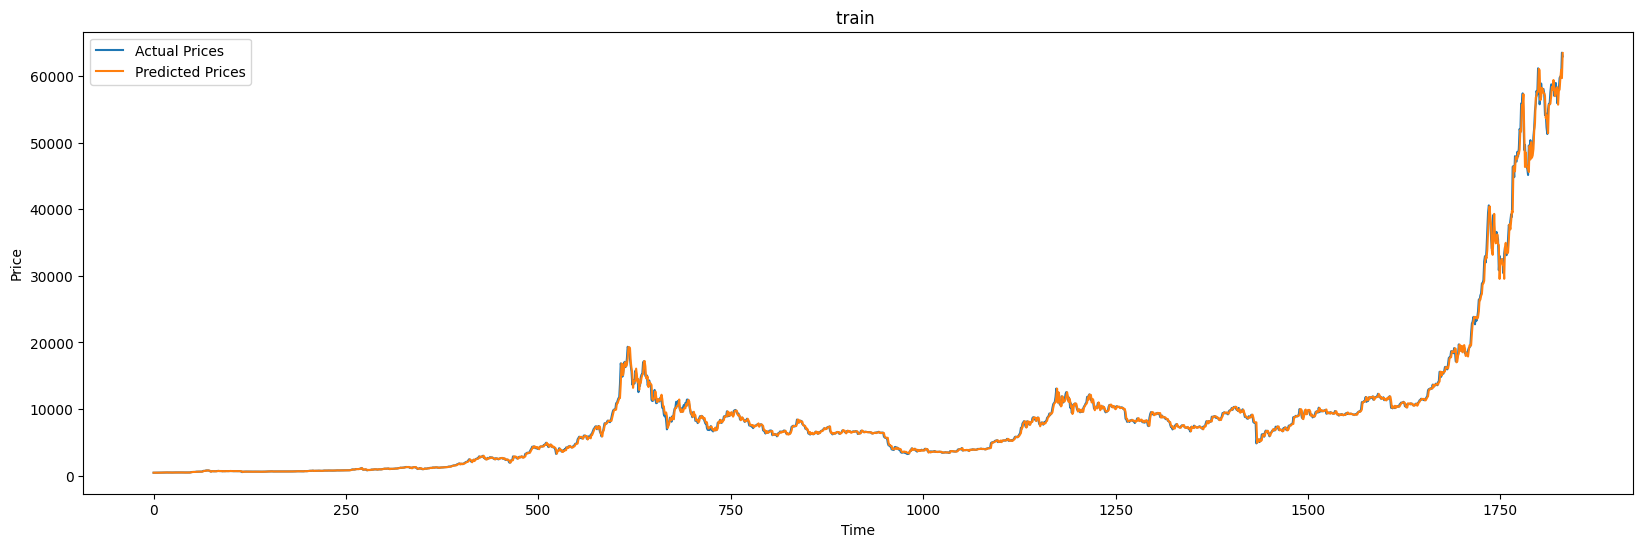

In [17]:
# Plot the predicted and actual prices
plt.figure(figsize=(20,6))
plt.plot(inverse_train_true, label='Actual Prices')
plt.plot(inverse_train_pred, label='Predicted Prices')

plt.title('train ')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

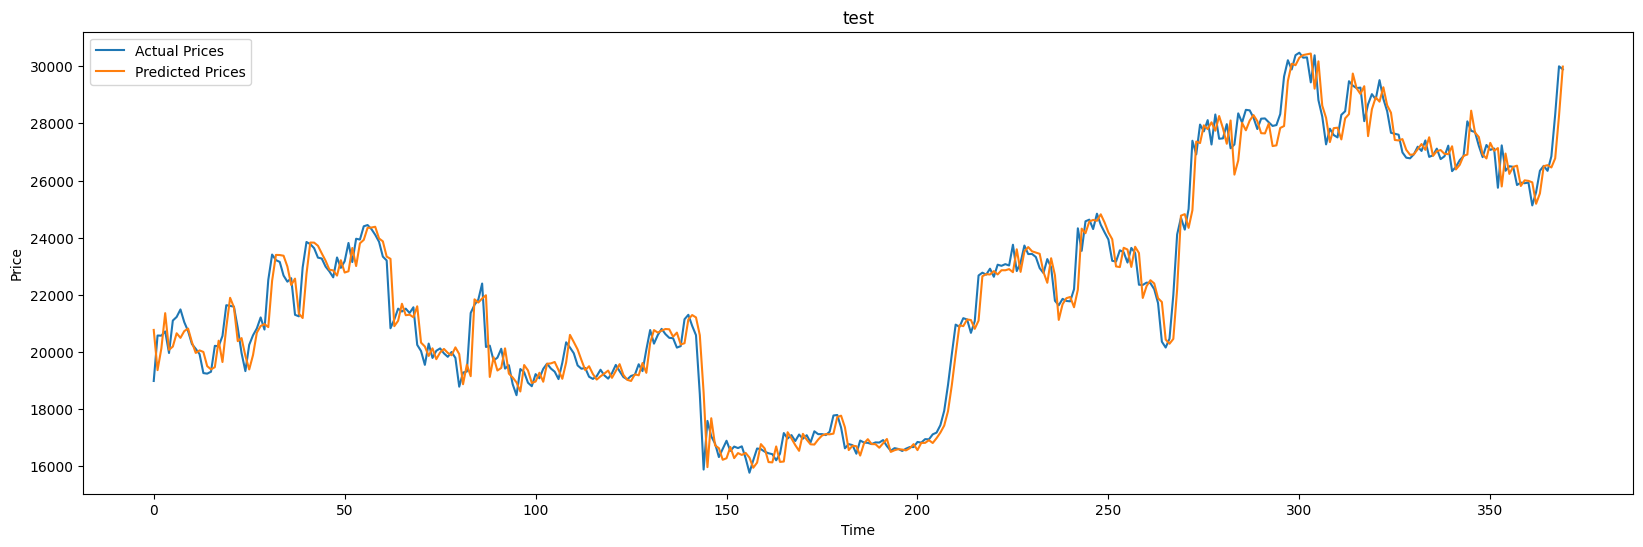

In [18]:
# Plot the predicted and actual prices
plt.figure(figsize=(20,6))
plt.plot(true_after_inverse, label='Actual Prices')
plt.plot(test_after_inverse, label='Predicted Prices')

plt.title('test')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [19]:

true_train=inverse_train_true
prediction_train=inverse_train_pred
prediction_test=test_after_inverse
true_test=true_after_inverse    
def print_evaluation_results(true_values, predicted_values, dataset_name):
    print("Test ACCuracy for", dataset_name)
    print("------------------------------------------------------")
    # RMSE
    rmse = np.sqrt(mean_squared_error(true_values, predicted_values))
    print("Root Mean Square Error (RMSE): {:.4f}".format(rmse))
    
    # MAPE
    mape = mean_absolute_percentage_error(true_values, predicted_values)
    print("Mean Absolute Percentage Error (MAPE): {:.4f}".format(mape))


    #r2 score
    print("R2 score: ", r2_score(true_values,predicted_values))

# Print evaluation results for the train set
print_evaluation_results(true_train, prediction_train, "train set")

# Print evaluation results for the test set
print_evaluation_results(true_test, prediction_test, "test set")


Test ACCuracy for train set
------------------------------------------------------
Root Mean Square Error (RMSE): 579.4792
Mean Absolute Percentage Error (MAPE): 0.0267
R2 score:  0.997073066858301
Test ACCuracy for test set
------------------------------------------------------
Root Mean Square Error (RMSE): 642.0905
Mean Absolute Percentage Error (MAPE): 0.0203
R2 score:  0.9737601295773403
